# CNN U-net for classifiying tree 3 (arborus verdesus ;P ) [Binary Classifier]

We will be classifying a specific tree (arborus verdesus :P).

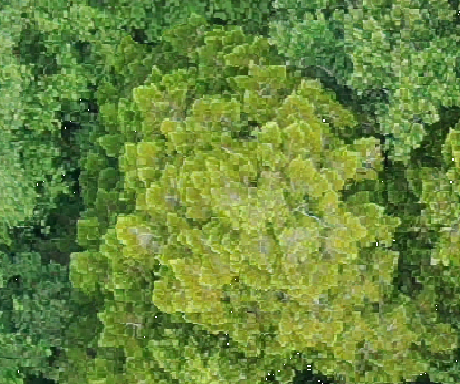
<!-- <center>
    <div>
        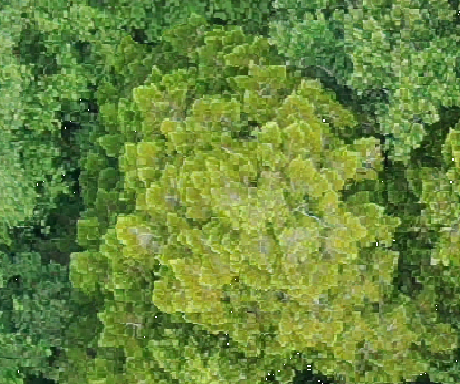
    </div>
</center> -->

I will be using the whole image because we need the results to stay georeferenced so we can interpret the results visually.

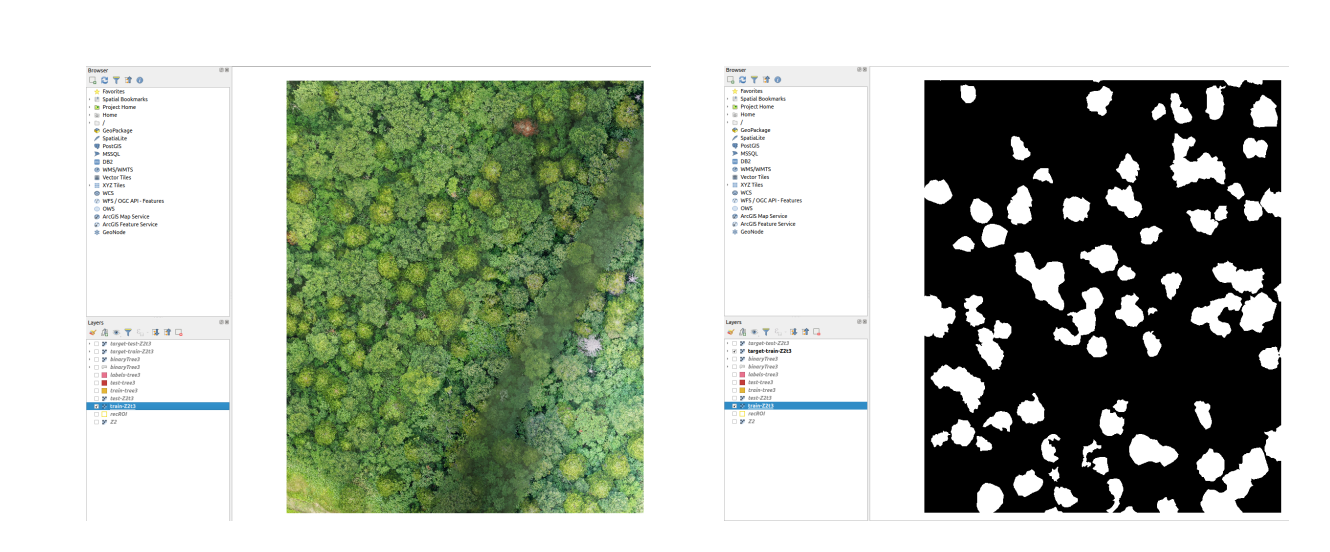
<!-- <center>
    <div>
        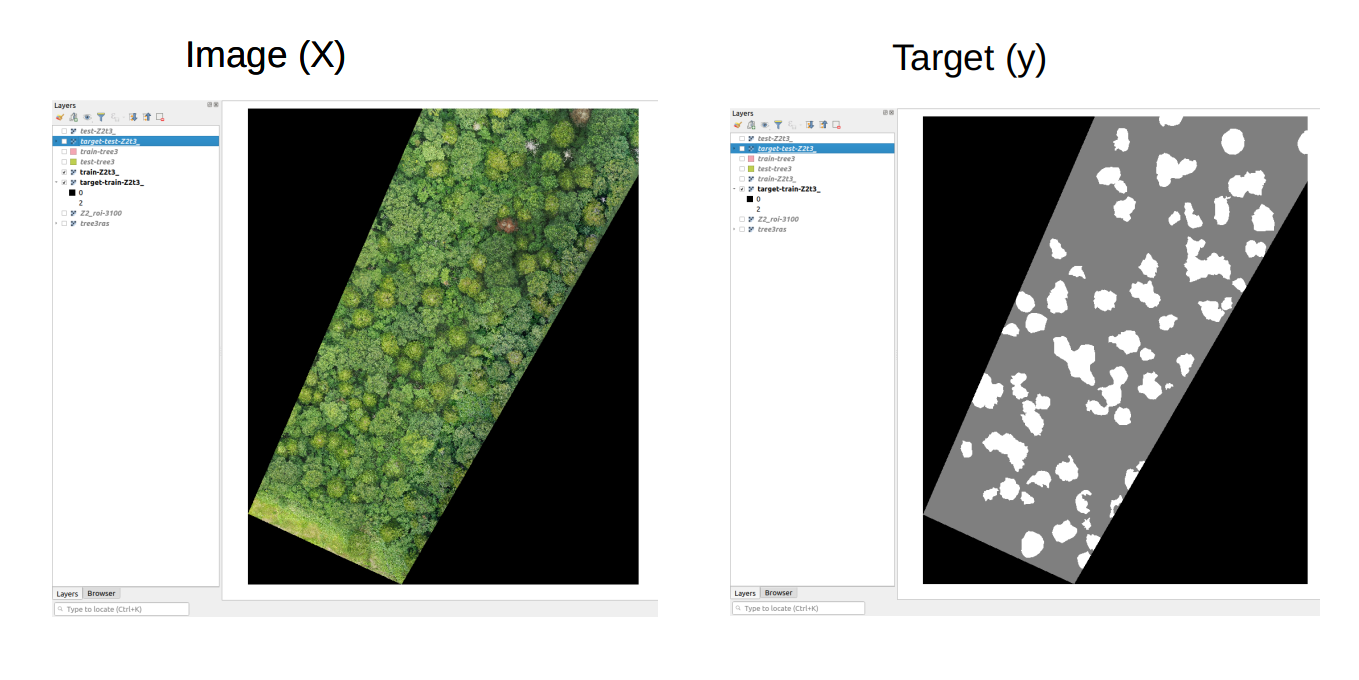
    </div>
</center> -->

Adapted U-net CNN-architecture for the tree species segmentation (Ronneberger et al., 2015). This scheme illustrates how 128 × 128 pixel tiles were analyzed. Values on top of the boxes depict the number of calculated feature maps with the respective x-y-dimensions as vertically oriented labels.

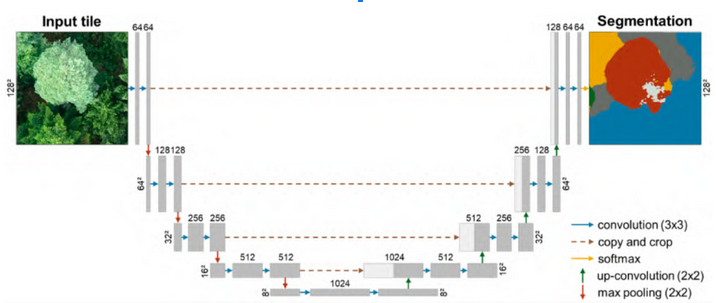
<!-- <center>
    <div>
        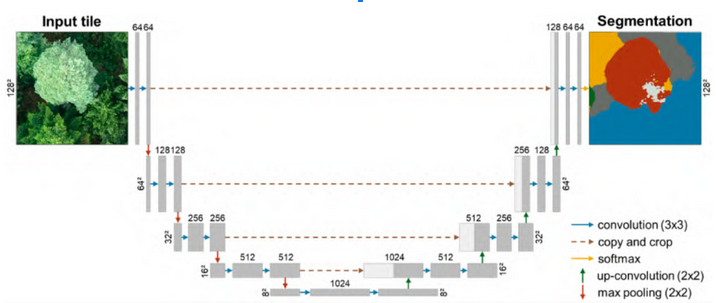
    </div>
</center> -->

In [1]:
# Import des modules Python nécessaires
import os
from PIL import Image
import cv2
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical

! Be careful to uncomment next line cropped images will be deleted

In [ ]:
!sh clearCroppingDir.sh

In [ ]:
def crop_images(savedir, filename, save_name):
    img = Image.open(filename)
    width, height = img.size
    w, h = (256, 256)

    frame_num = 1
    for col_i in range(0, width, w):
        for row_i in range(0, height, h):
            crop = img.crop((col_i, row_i, col_i + w, row_i + h))
            save_to = os.path.join(savedir, save_name + "_{:03}.jpg")
            crop.save(save_to.format(frame_num))
            frame_num += 1


crop_images("./Cropped/test", "./Data/test-Z2t3.tif", "test")
crop_images("./Cropped/train", "./Data/train-Z2t3.tif", "train")
crop_images("./Cropped/target-test", "./Data/target-test-Z2t3.tif", "target-test")
crop_images("./Cropped/target-train", "./Data/target-train-Z2t3.tif", "target-train")

In [2]:
files_test = glob.glob("./Cropped/test/*.jpg")
files_test.sort()
files_train = glob.glob("./Cropped/train/*.jpg")
files_train.sort()
files_tar_test = glob.glob("./Cropped/target-test/*.jpg")
files_tar_test.sort()
fileTest = glob.glob("./Data/test-Z2t3.tif")
fileTarTest = glob.glob("./Data/target-test-Z2t3.tif")
files_tar_train = glob.glob("./Cropped/target-train/*.jpg")
files_tar_train.sort()

In [3]:
files_test[:10]

['./Cropped/test/test_001.jpg',
 './Cropped/test/test_002.jpg',
 './Cropped/test/test_003.jpg',
 './Cropped/test/test_004.jpg',
 './Cropped/test/test_005.jpg',
 './Cropped/test/test_006.jpg',
 './Cropped/test/test_007.jpg',
 './Cropped/test/test_008.jpg',
 './Cropped/test/test_009.jpg',
 './Cropped/test/test_010.jpg']

In [4]:
fileTarTest

['./Data/target-test-Z2t3.tif']

Here are the tiles (cropped from original)

Voici image
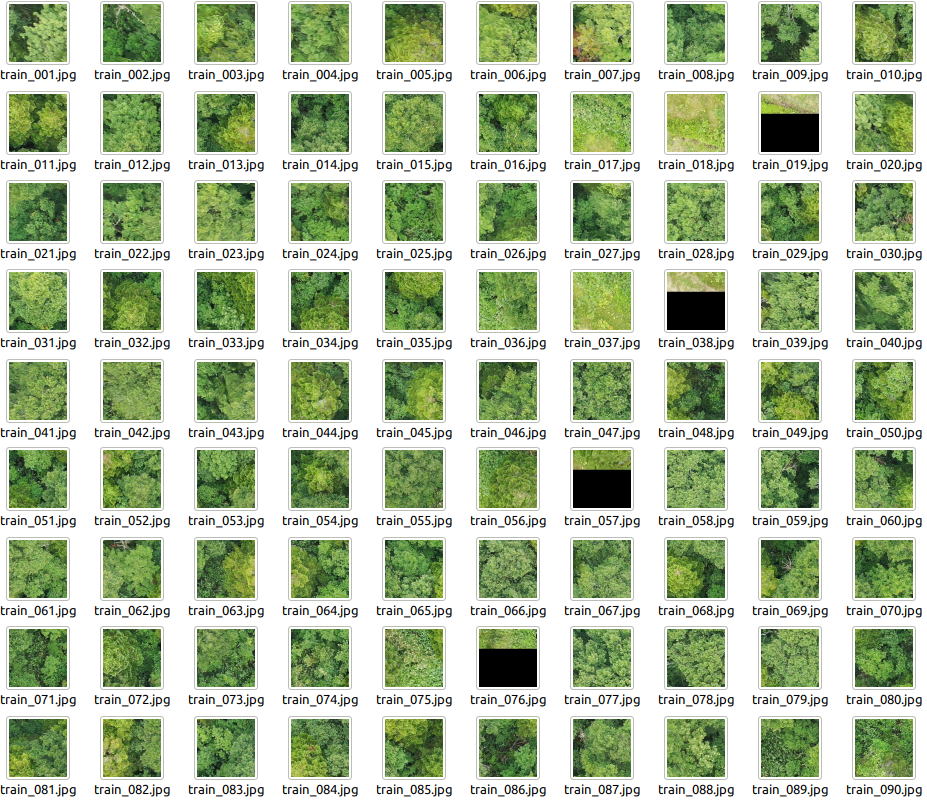

In [ ]:
# X = np.array(Image.open("./Data/train-Z2t3_.tif"))
# y = np.array(Image.open("./Data/target-train-Z2t3_.tif"))

In [5]:
X = []
for myFile in files_train:
    image = cv2.imread(myFile)
    X.append(image)

X = np.array(X)
print('X:', X.shape)

X: (357, 256, 256, 3)


In [6]:
y = []
for myFile in files_tar_train:
    image = cv2.imread(myFile)
    y.append(image)

y = np.array(y)
print('y:', y.shape)

y: (357, 256, 256, 3)


In [7]:
# Construction d'un RNA convolutif
CNN = Sequential([Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                  Conv2D(64, (3, 3), padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),
                  Conv2D(128, (3, 3), padding='same', activation='relu'),
                  Conv2D(128, (3, 3), padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),
                  Conv2D(256, (3, 3), padding='same', activation='relu'),
                  Conv2D(256, (3, 3), padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),
                  Conv2D(512, (3, 3), padding='same', activation='relu'),
                  Conv2D(512, (3, 3), padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),
                  Conv2D(1024, (3, 3), padding='same', activation='relu'),
                  UpSampling2D(size=(2, 2)),
                  Conv2D(512, (3, 3), padding='same', activation='relu'),
                  Conv2D(512, (3, 3), padding='same', activation='relu'),
                  UpSampling2D(size=(2, 2)),
                  Conv2D(256, (3, 3), padding='same', activation='relu'),
                  Conv2D(256, (3, 3), padding='same', activation='relu'),
                  UpSampling2D(size=(2, 2)),
                  Conv2D(128, (3, 3), padding='same', activation='relu'),
                  Conv2D(128, (3, 3), padding='same', activation='relu'),
                  UpSampling2D(size=(2, 2)),
                  Conv2D(64, (3, 3), padding='same', activation='relu'),
                  Conv2D(64, (3, 3), padding='same', activation='relu'),
                  Conv2D(3, (1, 1), activation='softmax')])
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       2

In [8]:
CNN.compile(optimizer='rmsprop', 
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_CNN = CNN.fit(X,
                      y,
                      verbose=True,
                      epochs=1,
                      validation_split=0.3)

4/8 [==============>...............] - ETA: 5:10 - loss: 480908897419264.0000 - accuracy: 0.2595

In [ ]:
history_CNN.history

In [ ]:
Xtest = []
for myFile in fileTest:
    image = cv2.imread(myFile)
    Xtest.append(image)

Xtest = np.array(Xtest)

ytest = []
for myFile in fileTarTest:
    image = cv2.imread(myFile)
    ytest.append(image)

ytest = np.array(ytest)

In [ ]:
y_new = CNN.predict(Xtest)

In [ ]:
np.unique(y_new)

All nan ??

This code is for rolling back to original size to compare visually on Qgis or other

In [ ]:
# Roll back to origin
def get_offsets(file):
    return [int(dim[1:]) for dim in file.split('.')[2:4]]


get_offsets("./Data/target-train-Z2t3_.tif")

# Get the list of files
files = files_tar_train

if not files:
    print("No input files found")
else:
    print(str(len(files))+" input files found")
    lastFile = files[-1]
    outfile = lastFile[len('Train.'):].split('.')[0]+'_new.tif'

    # The width and height of the original image can be det from the last tile
    with Image.open(lastFile) as lastIm:
        w, h = lastIm.size
    x, y = get_offsets(lastFile)
    w += x
    h += y
    print("Combined image should be "+str(w)+" by "+str(h))

    # Create the new image
    im_out = Image.new(lastIm.mode, (w, h))
    for file in files:
        x, y = get_offsets(file)

        # Paste each tile
        with Image.open(file) as im:
            im_out.paste(im, (x, y))
    im_out.save(outfile)
    print("Image saved as "+outfile)